In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib notebook

# Logging visualization

This notebook operates under the assumption that a `TARDIS` `numba_montecarlo` run has already been completed, with the `log_decorator` enabled for `single_packet_loop`. It then visualizes the progress of packets through shells, depicting different interactions.

TODO: 
- animate packet progress
- include run of TARDIS in the notebook

In [2]:
# TODO: read these in from config file that was used. These are just from TARDIS example.

velocities = np.linspace(1.1e4, 20000, 21)  # km / s
velocities *= 1e5  # cm / s
t_explosion = 10  # days
t_explosion *= 24*60*60 # seconds
radii = velocities * t_explosion

In [3]:
log_file_path = 'sample_montecarlo_log.log'  # change based on where the log file is

In [4]:
def assign_val(string):
    """
    Maps different interactions to a representation that allows for easier plotting.
    """
    if 'LINE' in string:
        return 2
    elif 'BOUNDARY' in string:
        return 1
    else:
        return 0

# Parse the log file
with open(log_file_path, "r") as file:
    for line in file:
        if 'Output' in line:
            output = line.split('Output: ')[1][:-2]
            interactions = output.split('<')[1:-1]
            interactions = [assign_val(interaction) for interaction in interactions]
            last = output.split('<')[-1].split('>')[0]
            interactions += [assign_val(last)]
            break

In [5]:
def plot_packet_from_logs(log_file_path, max_plotted=500):
    """
    Used to track the progress of single packets.
    log_file_path: name of log.
    
    Inputs:
        log_file_path (string): path to log file.
        max_plotted (int, default 500): max number of packets that are plotted.
    """

    fig = plt.figure(figsize=(7, 7))
    ax = plt.gca()
    ax.set_ylim(-1.9e15, 1.9e15)
    ax.set_xlim(-1.9e15, 1.9e15)
    ax.set_xlabel('Distance (cm)', fontsize=18)
    ax.set_ylabel('Distance (cm)', fontsize=18)
    for i, r in enumerate(radii): # need to fix this
        ax.add_patch(mpl.patches.Circle((0, 0), r, edgecolor='black',
                                            facecolor='none'))
        ax

    ticker = 0
    with open(log_file_path, "r") as file:
        for line in file:
            if 'Output' in line and ticker < max_plotted:
                output = line.split('Output: ')[1][:-2]
                
                interactions = output.split('<')[1:-1]
                interactions = [assign_val(interaction) for interaction in interactions]
                last = output.split('<')[-1].split('>')[0]
                interactions += [assign_val(last)]
            
                r_track_distance = eval('[' + output.split('[')[-1][:-1])
                if None in r_track_distance or 'stop' in r_track_distance:
                    r_track_distance = r_track_distance[0]
                rel_output = output.split(', [<InteractionType.BOUNDARY')[0]
                formatted = rel_output + ')'
                r_track_nu, r_track_mu, r_track_r = eval(formatted)
                r_track_r = np.array(r_track_r)
                r_track_distance = np.array(r_track_distance)
                angle = np.cumsum(np.arccos((r_track_r[:-1] ** 2 + r_track_r[
                                                               1:] ** 2 - r_track_distance[
                                                                          1:] ** 2) / (
                                                    2 * r_track_r[:-1] * r_track_r[
                                                                         1:])))
                x, y = np.sin(angle) * r_track_r[1:], np.cos(angle) * r_track_r[1:]
                x = np.hstack(([0], x))
                y = np.hstack((r_track_r[0], y))
                ax.plot([x[0]], [y[0]], marker='o', color='gray')
                ax.plot(x, y, color='gray', alpha=.2)
                plt.scatter(x[interactions==1], y[interactions==1], marker='o')
                plt.scatter(x[interactions==2], y[interactions==2], marker='+')
                ticker += 1
                interactions = np.array(interactions)
        try:
#             ax.plot(x, y, marker='x', color='goldenrod', alpha=.2, label='Packet paths')
            ax.plot(x, y, color='red', label='Last valid packet')
            ax.scatter(x[interactions==1], y[interactions==1], marker='o', color='red', label='Boundary interaction')
            ax.scatter(x[interactions==2], y[interactions==2], marker='+', color='red', s=75, label='Line interaction')
            ax.plot([x[0]], [y[0]], marker='o', color='gray', label='Starting point')
            plt.legend(fontsize=18, loc='upper right')
        except UnboundLocalError:
            print('No packets traveled!')
    plt.savefig('tardis_viz.pdf')
    plt.show()

<IPython.core.display.Javascript object>


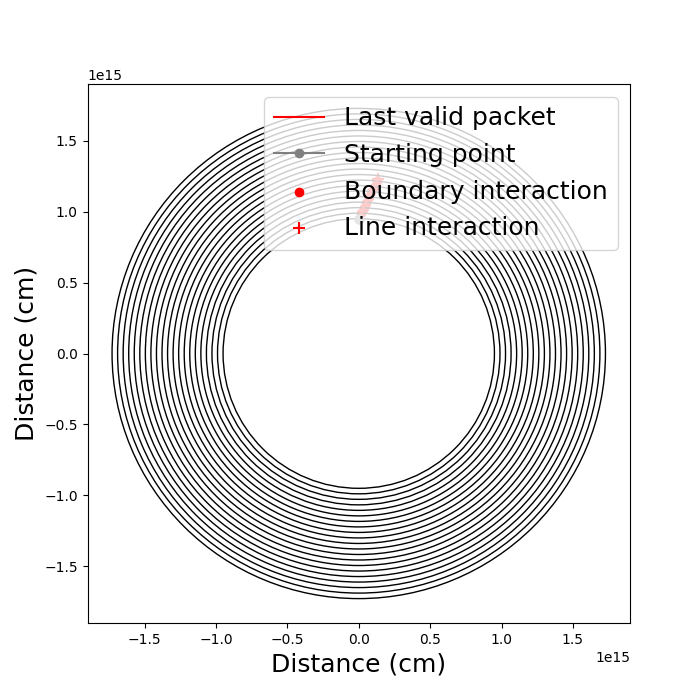

In [6]:
plot_packet_from_logs(log_file_path)